In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import json
import os

from skimage.io import imread, imshow
from skimage.filters import gaussian, threshold_otsu
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Open json files
with open('image_list.json') as train_data:
    images = json.load(train_data)

In [3]:
# Create dataframe with image names
df = pd.DataFrame(data=images,columns=['images'])

In [4]:
text_list = os.listdir('labels') # extract text labels

In [5]:
result = []
for angles in text_list:
    f = open(f'labels\{angles}','r')
    result.append(f.readline())

In [6]:
# Convert all strings on the list to float variables
actual_rotation = []
for i in result:
    actual_rotation.append(float(i))

In [7]:
first_image = imread('images/scan_000.png')

Initial image before undergoing filtering


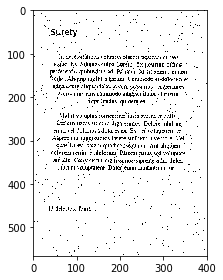

In [8]:
print('Initial image before undergoing filtering')
imshow(first_image);

In [9]:
first_image.shape

(566, 400)

### Analysis of the image before image filtering is applied

### 1. Neural Network Model Construction

In [10]:
def build_model():
    model = Sequential([
        Dense(64, activation='relu',input_shape=(train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

In [11]:
my_images = [] # list to be filled with images

# Loop function to process the images 
for img in images:
    image = imread(f'images/{img}')
    inverted_image = np.invert(image) # Black --> White, White --> Black
    
    inverted_image = inverted_image.reshape(inverted_image.shape[0] * inverted_image.shape[1])
    inverted_image = inverted_image.astype('float32') / 255
    my_images.append(inverted_image)

In [12]:
my_images = np.array(my_images)

In [13]:
my_images.shape

(500, 226400)

In [14]:
labels = np.array(actual_rotation)

In [15]:
len(my_images)

500

In [16]:
len(labels)

500

In [60]:
k = 4 # number of folds
train = my_images[:400]
train_labels = labels[:400]
test = my_images[400:]
test_labels = labels[400:]
num_val_samples = len(train) // k
num_epochs = 50
mae_scores = []
val_mae_scores = []
for i in range(k):
    print('processing fold #', i)
    val_images = train[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_images = np.concatenate([
        train[:i * num_val_samples],
        train[(i + 1) * num_val_samples:]
    ],axis=0)
    partial_train_labels = np.concatenate([
        train_labels[:i * num_val_samples],
        train_labels[(i + 1) * num_val_samples:]
    ],axis=0)
    
    model = build_model()
    history = model.fit(partial_train_images, partial_train_labels, 
                        validation_data=(val_images, val_labels),
                        epochs=num_epochs, batch_size=1, verbose=0)
    val_mae_scores.append(history.history['val_mae'])
    mae_scores.append(history.history['mae'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [61]:
average_val_mae_history_unfiltered = [
    np.mean([x[i] for x in val_mae_scores]) for i in range(num_epochs)
]

In [62]:
average_mae_history_unfiltered = [
    np.mean([x[i] for x in mae_scores]) for i in range(num_epochs)
]

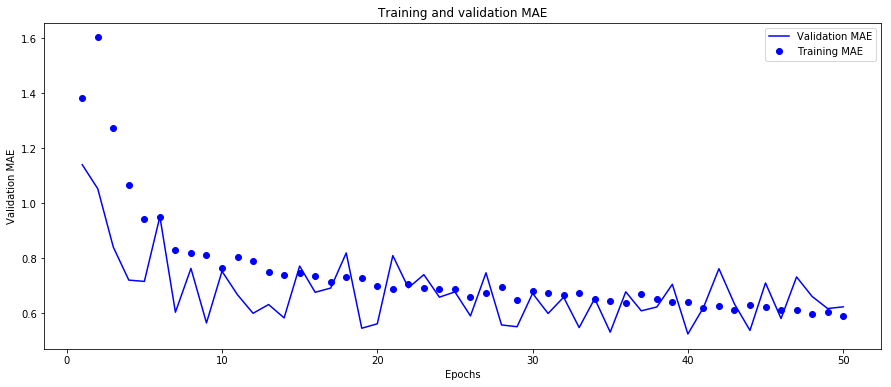

In [65]:
# The requirement is to get MAE less than 1 degree
plt.figure(figsize=(15,6))
plt.plot(range(1, len(average_val_mae_history_unfiltered) + 1), average_val_mae_history_unfiltered, 'b', label='Validation MAE')
plt.plot(range(1, len(average_mae_history_unfiltered) + 1), average_mae_history_unfiltered, 'bo', label='Training MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE');
plt.legend()

In [66]:
model.fit(train, train_labels, epochs=9, batch_size=20)

Train on 400 samples
Epoch 1/9
400/400 [==============================] - 5s 11ms/sample - loss: 0.3213 - mae: 0.4073
Epoch 2/9
400/400 [==============================] - 4s 10ms/sample - loss: 0.2096 - mae: 0.3427
Epoch 3/9
400/400 [==============================] - 4s 10ms/sample - loss: 0.2348 - mae: 0.3638
Epoch 4/9
400/400 [==============================] - 4s 10ms/sample - loss: 0.2064 - mae: 0.3238
Epoch 5/9
400/400 [==============================] - 4s 10ms/sample - loss: 0.2758 - mae: 0.3746
Epoch 6/9
400/400 [==============================] - 4s 10ms/sample - loss: 0.2274 - mae: 0.3459
Epoch 7/9
400/400 [==============================] - 4s 10ms/sample - loss: 0.2302 - mae: 0.3298
Epoch 8/9
400/400 [==============================] - 4s 10ms/sample - loss: 0.1941 - mae: 0.3197
Epoch 9/9
400/400 [==============================] - 4s 10ms/sample - loss: 0.2085 - mae: 0.3415


In [68]:
_, mae_unfiltered_nn = model.evaluate(test, test_labels)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [69]:
print('The mean absolute error is', mae_unfiltered_nn)

The mean absolute error is 0.36376676


### Analysis when image is filtered

In [70]:
myimages = [] # list to be filled with images

# Loop function to process the images and apply necessary filtering
for img in images:
    image = imread(f'images/{img}')
    inverted_image = np.invert(image) # Black --> White, White --> Black
    for i in range(inverted_image.shape[0]):
        for j in range(inverted_image.shape[1]):
            if inverted_image[i,j] != 0:
                # Starting from the top-left corner of a 3x3 Grid and going clockwise around the center of the grid 
                # This will display data of surrounding blocks from the central point (i.e) point of interest
                mylist = [
                    [i-1,j-1], # top-left
                    [i-1,j], # top-center
                    [i-1,j+1], # top-right
                    [i,j+1], # mid-right
                    [i+1,j+1], # bottom-right
                    [i+1,j], # bottom-center
                    [i+1,j-1], # bottom-left
                    [i,j-1] # mid-left
                ] # Negative number means the grid is off the image, therefore discard only a pair with at least one negative number
                img_list = [[x,y] for x,y in mylist if x >= 0 and y >= 0 and x < inverted_image.shape[0] and y < inverted_image.shape[1]]

                # The img_list must run through the inverted image
                pixel = 0 
                for nums in img_list:
                    pixel += inverted_image[nums[0],nums[1]] 
                
                # Removing the salt & pepper from the image
                if pixel == 0: #checking if the white dot is surrounded by black space hence why I inverted the image
                    inverted_image[i,j] = 0 #i.e if true remove the white dot and turn it black
    
    inverted_image = inverted_image.reshape(inverted_image.shape[0] * inverted_image.shape[1])
    inverted_image = inverted_image.astype('float32') / 255
    myimages.append(inverted_image)

Initial image before undergoing filtering - inverted


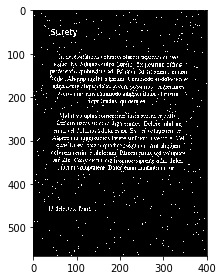

In [71]:
print('Initial image before undergoing filtering - inverted')
imshow(np.invert(first_image));

Image after undergoing processing and filtering


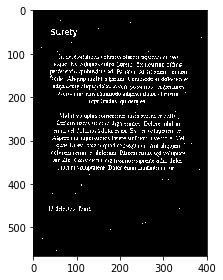

In [72]:
print('Image after undergoing processing and filtering')
imshow(myimages[0].reshape(566, 400));

In [73]:
myimages = np.array(myimages)

In [74]:
myimages.shape

(500, 226400)

In [75]:
labels = np.array(actual_rotation)

In [76]:
k = 4 # number of folds
train = myimages[:400]
train_labels = labels[:400]
test = myimages[400:]
test_labels = labels[400:]
num_val_samples = len(train) // k
num_epochs = 50
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_images = train[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_images = np.concatenate([
        train[:i * num_val_samples],
        train[(i + 1) * num_val_samples:]
    ],axis=0)
    partial_train_labels = np.concatenate([
        train_labels[:i * num_val_samples],
        train_labels[(i + 1) * num_val_samples:]
    ],axis=0)
    
    model = build_model()
    history = model.fit(partial_train_images, partial_train_labels, 
                        validation_data=(val_images, val_labels),
                        epochs=num_epochs, batch_size=1, verbose=0)
    val_mae_scores.append(history.history['val_mae'])
    mae_scores.append(history.history['mae'])

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [77]:
average_val_mae_history_filtered = [
    np.mean([x[i] for x in val_mae_scores]) for i in range(num_epochs)
]

In [78]:
average_mae_history_filtered = [
    np.mean([x[i] for x in mae_scores]) for i in range(num_epochs)
]

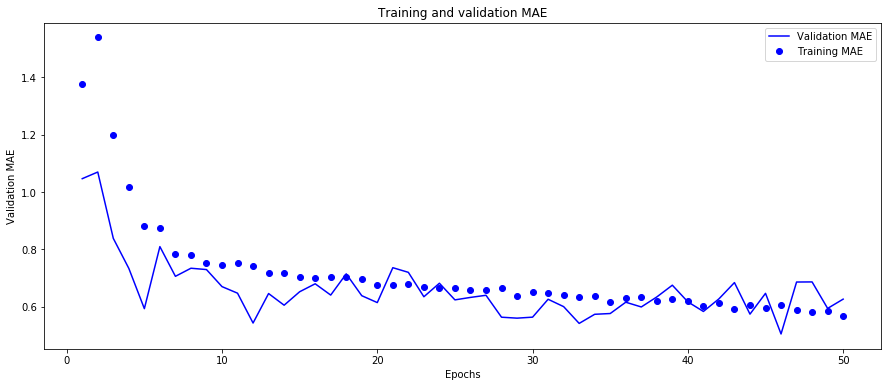

In [79]:
plt.figure(figsize=(15,6))
plt.plot(range(1, len(average_val_mae_history_filtered) + 1), average_val_mae_history_filtered, 'b', label='Validation MAE')
plt.plot(range(1, len(average_mae_history_filtered) + 1), average_mae_history_filtered, 'bo', label='Training MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE');
plt.legend()

In [80]:
model.fit(train, train_labels, epochs=12, batch_size=20)

Train on 400 samples
Epoch 1/12
400/400 [==============================] - 8s 19ms/sample - loss: 0.2703 - mae: 0.3926
Epoch 2/12
400/400 [==============================] - 4s 10ms/sample - loss: 0.2427 - mae: 0.3660
Epoch 3/12
400/400 [==============================] - 4s 10ms/sample - loss: 0.1836 - mae: 0.2986
Epoch 4/12
400/400 [==============================] - 4s 10ms/sample - loss: 0.2296 - mae: 0.3457
Epoch 5/12
400/400 [==============================] - 4s 10ms/sample - loss: 0.2263 - mae: 0.3448
Epoch 6/12
400/400 [==============================] - 4s 10ms/sample - loss: 0.1748 - mae: 0.3141
Epoch 7/12
400/400 [==============================] - 4s 10ms/sample - loss: 0.1790 - mae: 0.3149
Epoch 8/12
400/400 [==============================] - 4s 10ms/sample - loss: 0.1404 - mae: 0.2799
Epoch 9/12
400/400 [==============================] - 4s 10ms/sample - loss: 0.1747 - mae: 0.3155
Epoch 10/12
400/400 [==============================] - 4s 10ms/sample - loss: 0.1584 - mae: 0.287

In [81]:
_, mae_filtered_nn = model.evaluate(test, test_labels)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [82]:
print('The mean absolute error is', mae_filtered_nn)
print('Unfiltered image MAE is', mae_unfiltered_nn)

The mean absolute error is 0.34927773
Unfiltered image MAE is 0.36376676


### 2. Linear regression 

In [83]:
estimated_rotation = [] # list to be filled 

for img in images:
    image = imread(f'images/{img}')
    inverted_image = np.invert(image) # Black --> White, White --> Black
    for i in range(inverted_image.shape[0]):
        for j in range(inverted_image.shape[1]):
            if inverted_image[i,j] != 0:
                # Starting from the top-left corner of a 3x3 Grid and going clockwise around the center of the grid 
                # This will display data of surrounding blocks from the central point (i.e) point of interest
                mylist = [
                    [i-1,j-1], # top-left
                    [i-1,j], # top-center
                    [i-1,j+1], # top-right
                    [i,j+1], # mid-right
                    [i+1,j+1], # bottom-right
                    [i+1,j], # bottom-center
                    [i+1,j-1], # bottom-left
                    [i,j-1] # mid-left
                ] # Negative number means the grid is off the image, therefore discard only a pair with at least one negative number
                img_list = [[x,y] for x,y in mylist if x >= 0 and y >= 0 and x < inverted_image.shape[0] and y < inverted_image.shape[1]]

                # The img_list must run through the inverted image
                pixel = 0 
                for nums in img_list:
                    pixel += inverted_image[nums[0],nums[1]] 

                if np.sum(pixel) == 0: #checking if the white dot is surrounded by black space hence why I inverted the image
                    inverted_image[i,j] = 0 #i.e if true remove the white dot and turn it black

    # To get rid of more noise missed
    thresh = threshold_otsu(inverted_image)
    normalize = image > thresh

    # Apply gaussian blur
    blur = gaussian(normalize, 3)

    # Increase the smoothing for better results
    edges = canny(blur)

    # Hough Lines
    hough_lines = probabilistic_hough_line(edges)

    # Calculate slope from hough lines, i.e. (change in y)/(change in x) 
    slopes = [(y2 - y1)/(x2 - x1) if (x2 - x1) else 0 for (x1, y1), (x2, y2) in hough_lines]

    # calc rotation in radians
    rad_angles = [np.arctan(x) for x in slopes]

    # change the rotation from radians to degrees
    deg_angles = [np.degrees(x) for x in rad_angles]

    # determine the mode
    hist_mode = np.histogram(deg_angles, bins=180)

    # correcting for 'sideways' alignments
    rotation = hist_mode[1][np.argmax(hist_mode[0])] 
    estimated_rotation.append(rotation)

In [105]:
mydf = pd.DataFrame(data=estimated_rotation, columns=['estimate'])

In [106]:
mydf['actual'] = actual_rotation

In [109]:
mydf.head()

,estimate,actual
0,-0.385354,-0.337674
1,2.092376,-2.227033
2,4.464840,-4.725058
3,4.808015,-4.799024
4,0.877921,-0.920912


In [150]:
mydf.shape

(500, 2)

In [115]:
# Training dataset
rotation_train = mydf[:300]

# Validation dataset
rotation_valid = mydf[300:400]

# Testing dataset
rotation_test = mydf[400:]

In [151]:
rotation_train.shape

(300, 2)

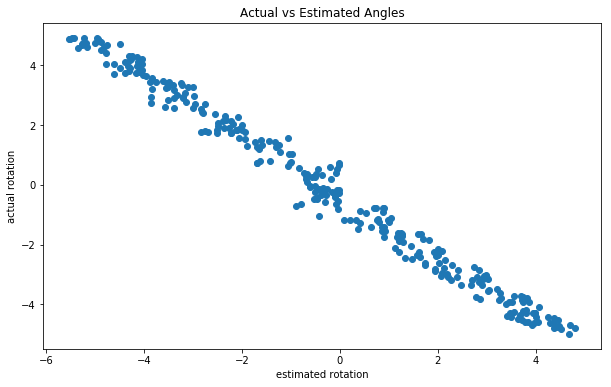

In [116]:
# Check the relationship between calculated image rotation angle and actual image rotation angle
plt.figure(figsize=(10,6))
plt.scatter(x=rotation_train['estimate'], y=rotation_train['actual'])
plt.title('Actual vs Estimated Angles')
plt.ylabel('actual rotation')
plt.xlabel('estimated rotation');

There's a negative relationship between estimated rotation and actual rotation. This might be due to different reference point for determining the angle of the skewed document.

In [117]:
lr = LinearRegression()

In [157]:
X_train = np.array(rotation_train['estimate']).reshape(-1,1)
y_train = np.array(rotation_train['actual']).reshape(-1,1)

In [159]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [160]:
X_valid = np.array(rotation_valid['estimate'], ndmin=2).reshape(-1, 1)
y_valid = np.array(rotation_valid['actual'], ndmin=2).reshape(-1, 1)

In [161]:
# predictions of validation data
pred_valid = lr.predict(X_valid)

In [163]:
mae_valid = mean_absolute_error(y_valid, pred_valid)
print(f'The mean absolute error for linear regression on validation data is: {mae_valid}')

The mean absolute error for linear regression on validation data is: 0.30381304967196715


In [164]:
X_test = np.array(rotation_test['estimate']).reshape(-1, 1)
y_test = np.array(rotation_test['actual']).reshape(-1, 1)

In [165]:
pred_test = lr.predict(X_test)

In [166]:
mae_test = mean_absolute_error(y_test, pred_test)
print(f'The mean absolute error for linear regression on the test data is: {mae_test}')

The mean absolute error for linear regression on the test data is: 0.32790778070252435


### Summary

In [168]:
summary = {
    'Neural Nets (unfiltered image)': mae_unfiltered_nn,
    'Neural Nets (filtered image)': mae_filtered_nn,
    'Linear Regression': mae_test
}

In [181]:
results = pd.DataFrame(data=summary.values(), columns=['MAE'], index=[x for x in summary.keys()])

In [182]:
results

,MAE
Neural Nets (unfiltered image),0.363767
Neural Nets (filtered image),0.349278
Linear Regression,0.327908
